# Determinación del número de semillas de una ornamental (Viola spp.), color y variables de forma.

## Sección 1. Importación de librerías e imagen

In [1]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [2]:
#Importanción de librerías

%matplotlib notebook
import os
import argparse
import matplotlib
import cv2
import numpy as np

from plantcv import plantcv as pcv

#Librería para contar número de objetos (Cálculo del número de Euler)
import mahotas



### Variables de entrada

In [6]:
# Input image into self.image (include file path if image is not in 
# the same folder as jupyter notebook)

# Set self.debug to "plot" so that image outputs for each step is shown
# once cell is run in jupyter notebooks (recommended)

class options:
    def __init__(self):        
        self.image = "./semillas.jpg"
        self.debug = "plot"
        self.writeimg = False
        self.result = "seed_analysis_results"
        self.outdir = "."

In [7]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

## Lectura de la imagen de entrada

<IPython.core.display.Javascript object>


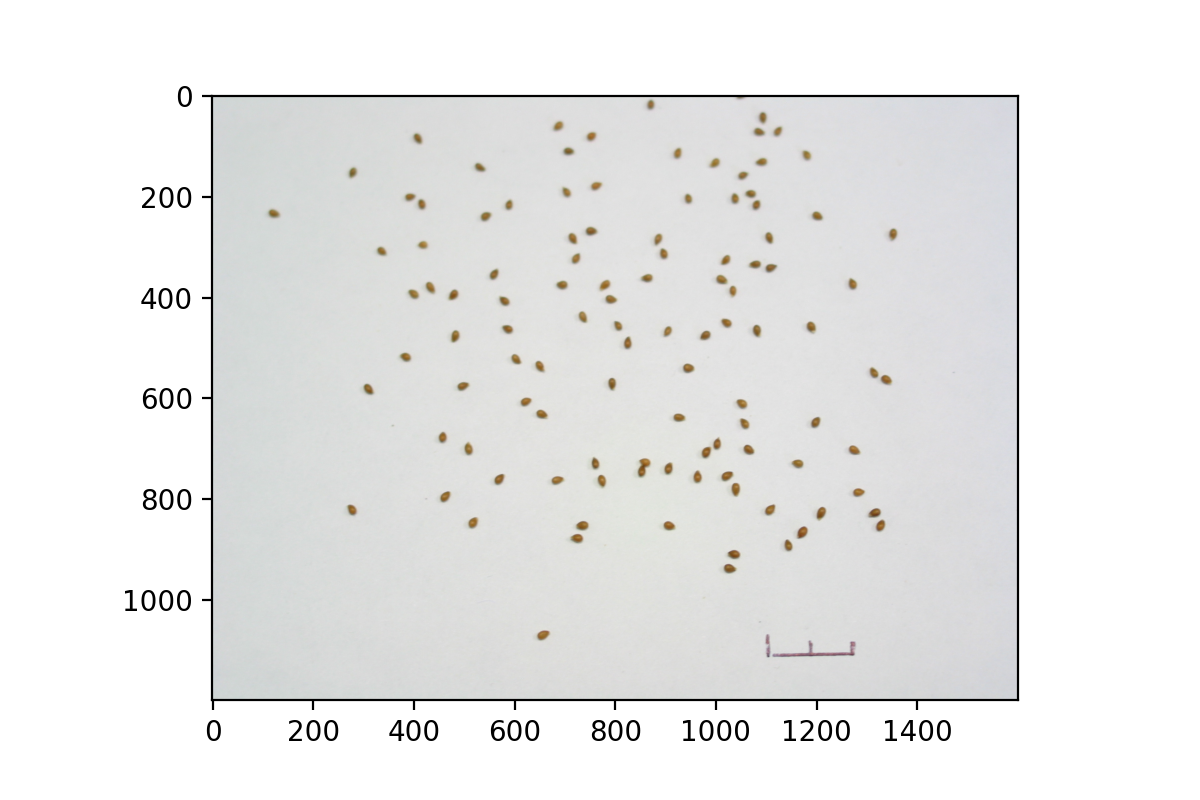

In [8]:
# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

## Sección 2. Segmentación e identificación de objetos

### Corte y selección del área de interés

<IPython.core.display.Javascript object>


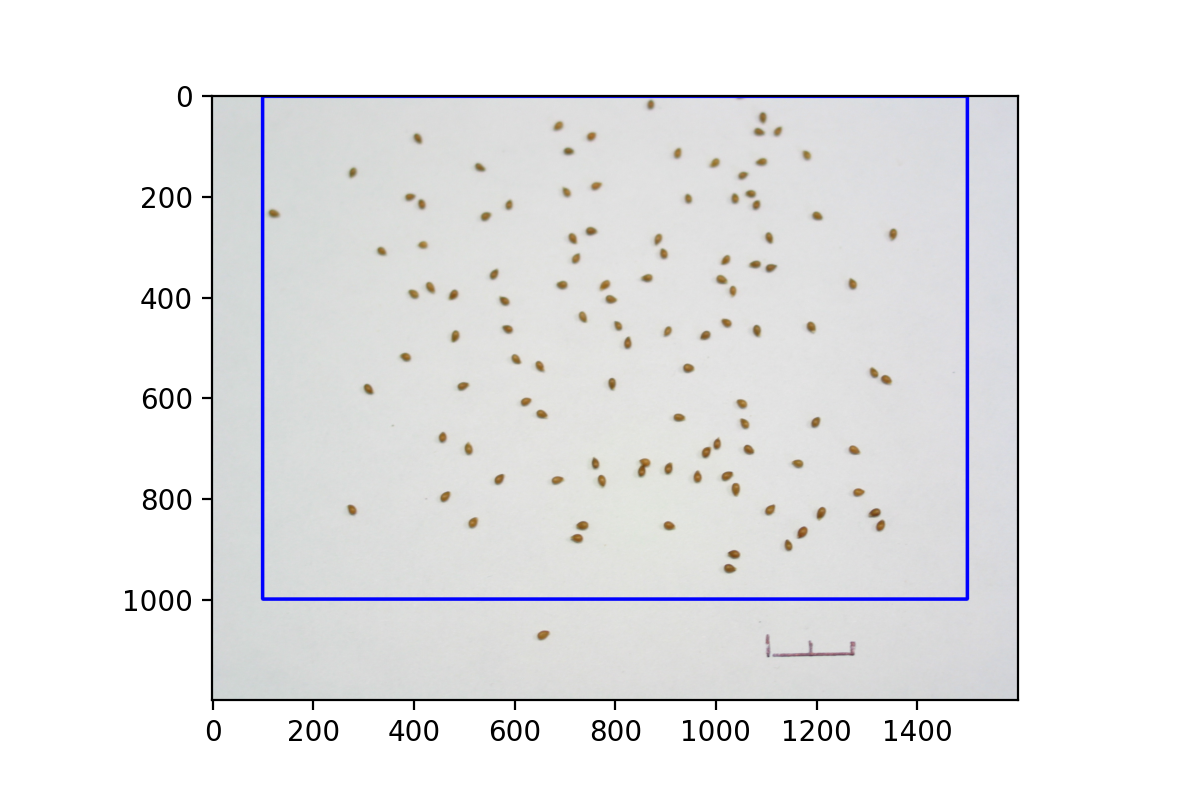

In [9]:
# Inputs:
#   x = top left x-coordinate
#   y = top left y-coordinate
#   h = height of final cropped image
#   w = width of final cropped image
img = pcv.crop(img=img, x=100, y=0, h=1000, w=1400)

### Visualización de los diversos espacios de color

<IPython.core.display.Javascript object>


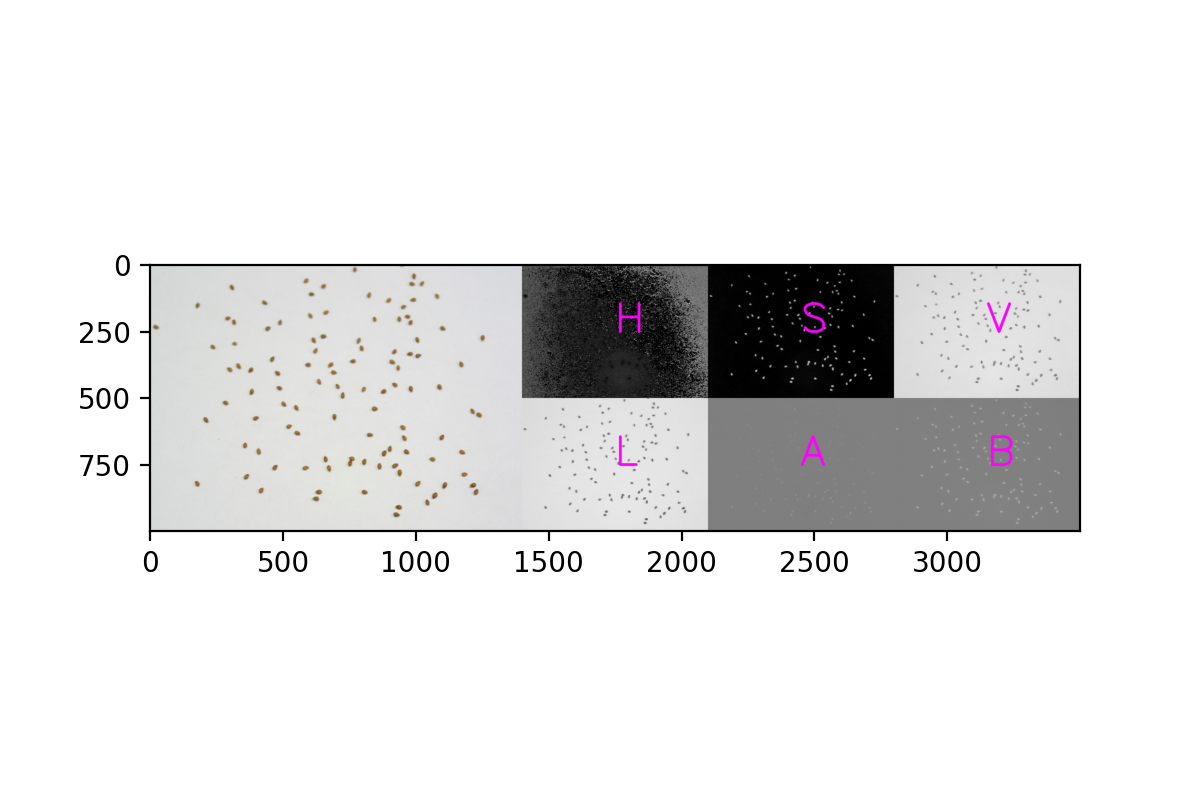

In [10]:
# Inputs:
#   rbg_img      = original image
#   original_img = whether to include the original RGB images in the display: True (default) or False
colorspace_img = pcv.visualize.colorspaces(rgb_img=img)

### Conversión de la imagen a escala de grises

<IPython.core.display.Javascript object>


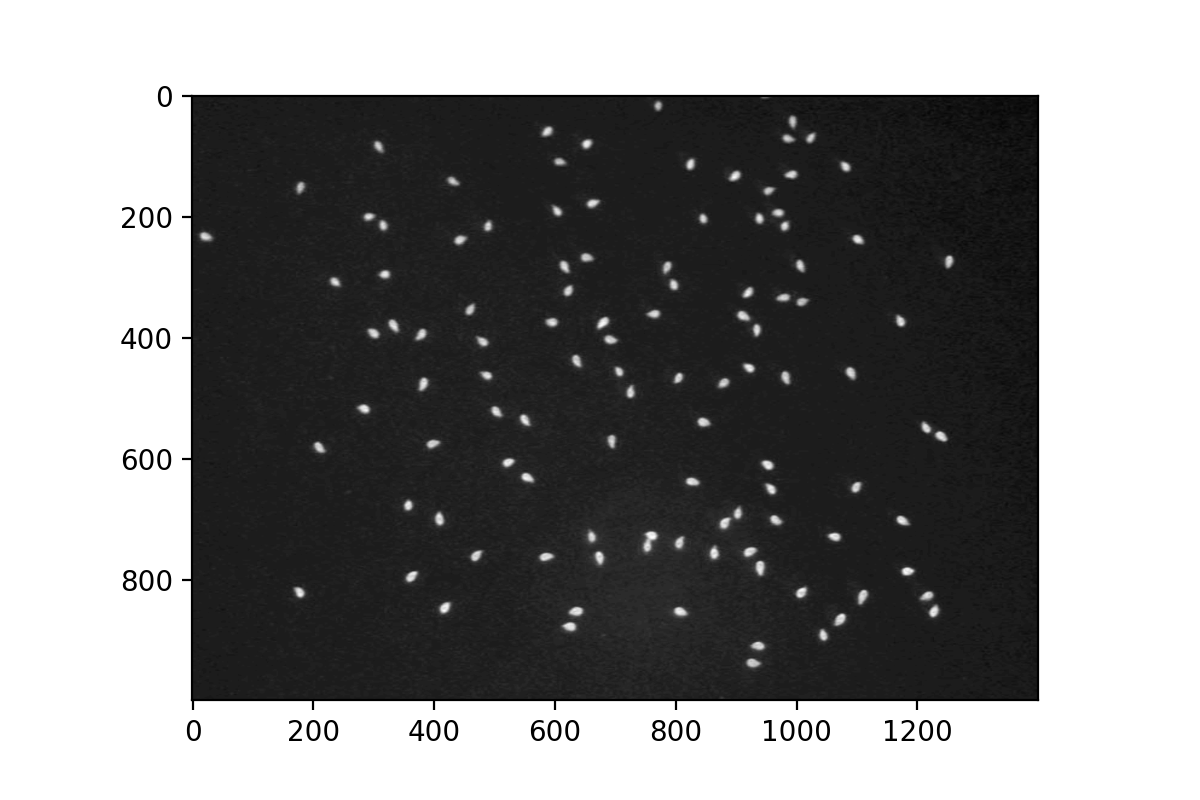

In [11]:
# Inputs:
#   rbg_img - original image
#   channel - desired colorspace ('l', 'a', or 'b')
b_img = pcv.rgb2gray_lab(rgb_img=img, channel='b')

### Se visualiza la distribución de los valores en escala de grises en una gráfica

<IPython.core.display.Javascript object>


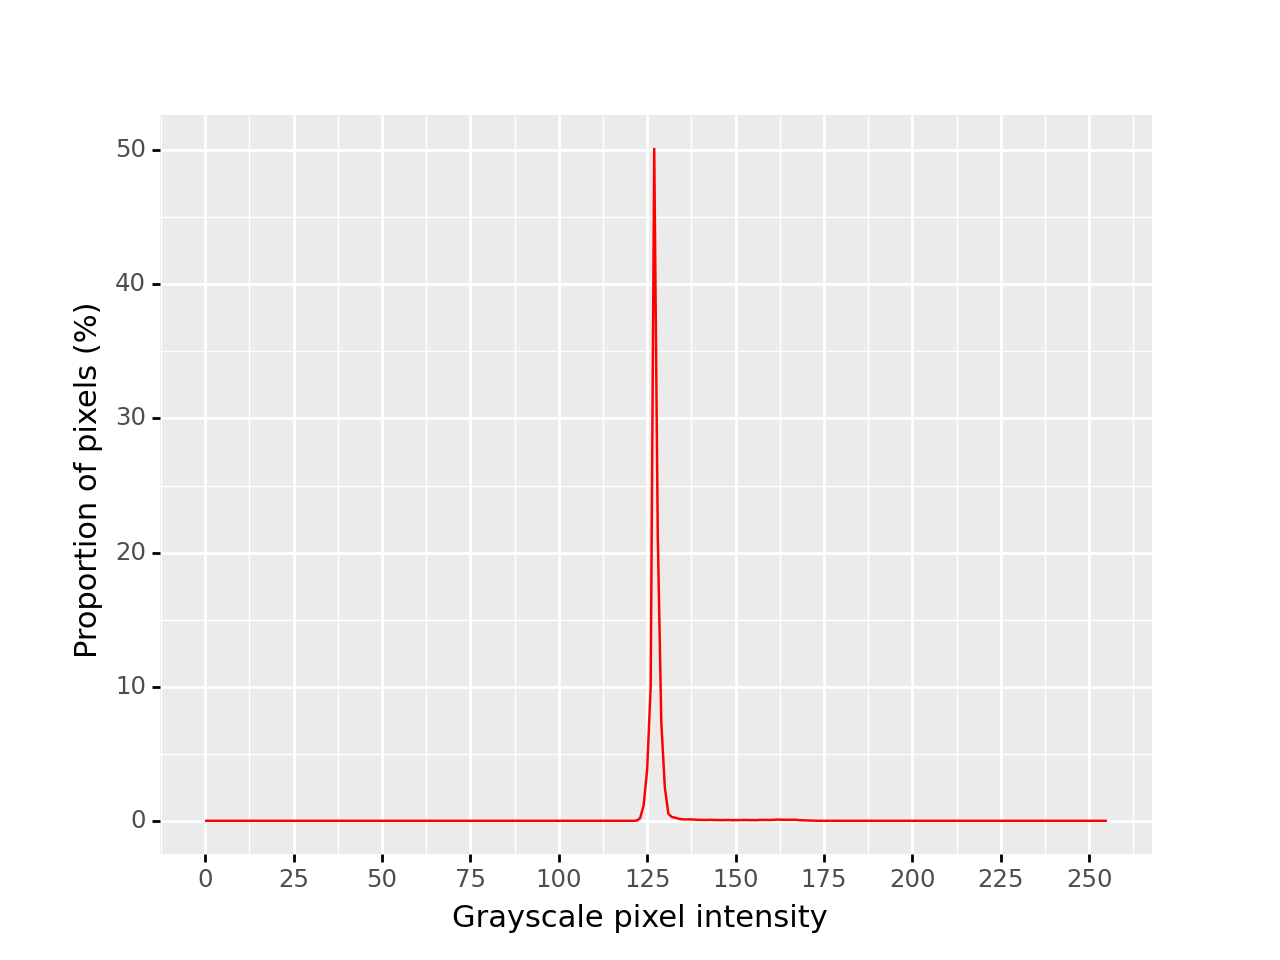

<ggplot: (328677645)>


In [12]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(b_img)

<IPython.core.display.Javascript object>


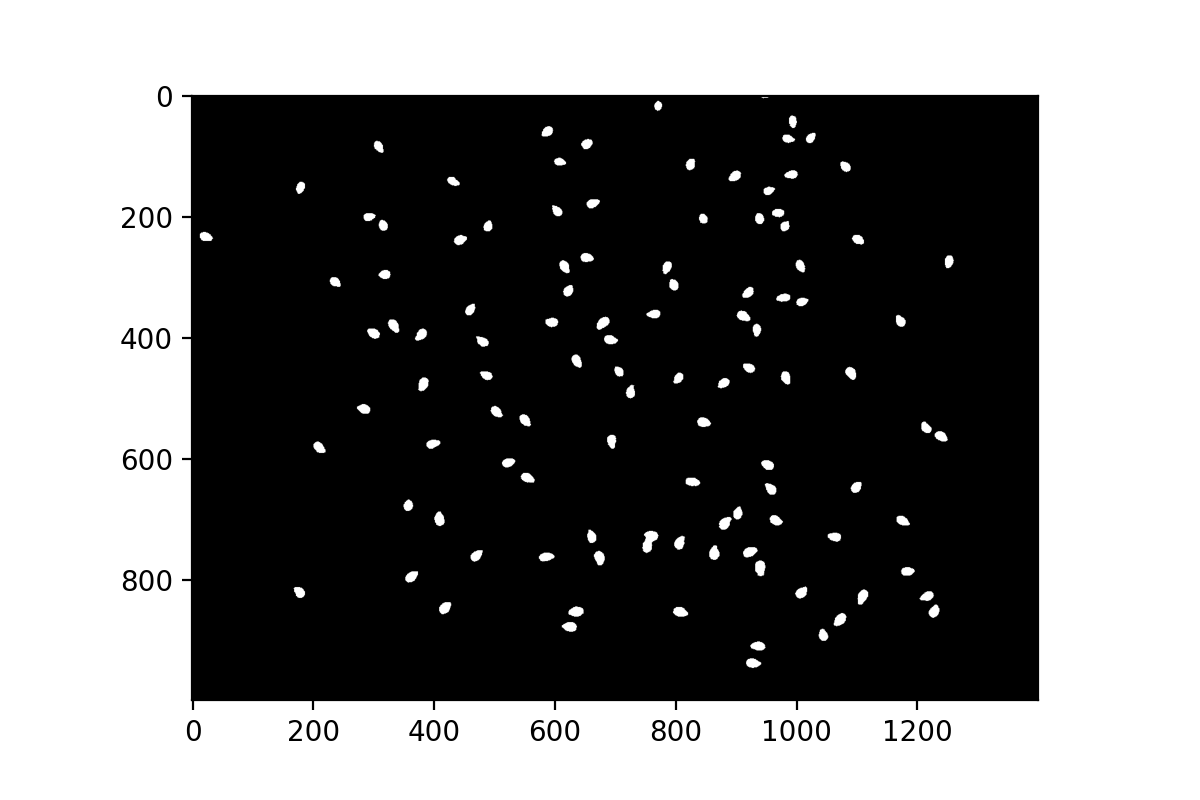

In [13]:
### Se definen umbrales

# Inputs:
#   gray_img    = black and white image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value   = maximum pixel value
#   object_type = 'dark' or 'light' depending on if seeds are darker or lighter than background
b_thresh = pcv.threshold.binary(gray_img=b_img, threshold=139, max_value=150, object_type='light')


## Eliminación de ruido del fondo, es decir eliminación de objetos de tamaño pequeño

La aplicación de un umbral asigna a los píxeles de la semilla un color blanco pero también hay pequeñas imperfecciones en los píxeles del fondo que se les asigna este color. La función "fill" elimina ruido del fondo llamado "sal" mediante un filtrado del fondo de acuerdo al tamaño de los objetos.

<IPython.core.display.Javascript object>


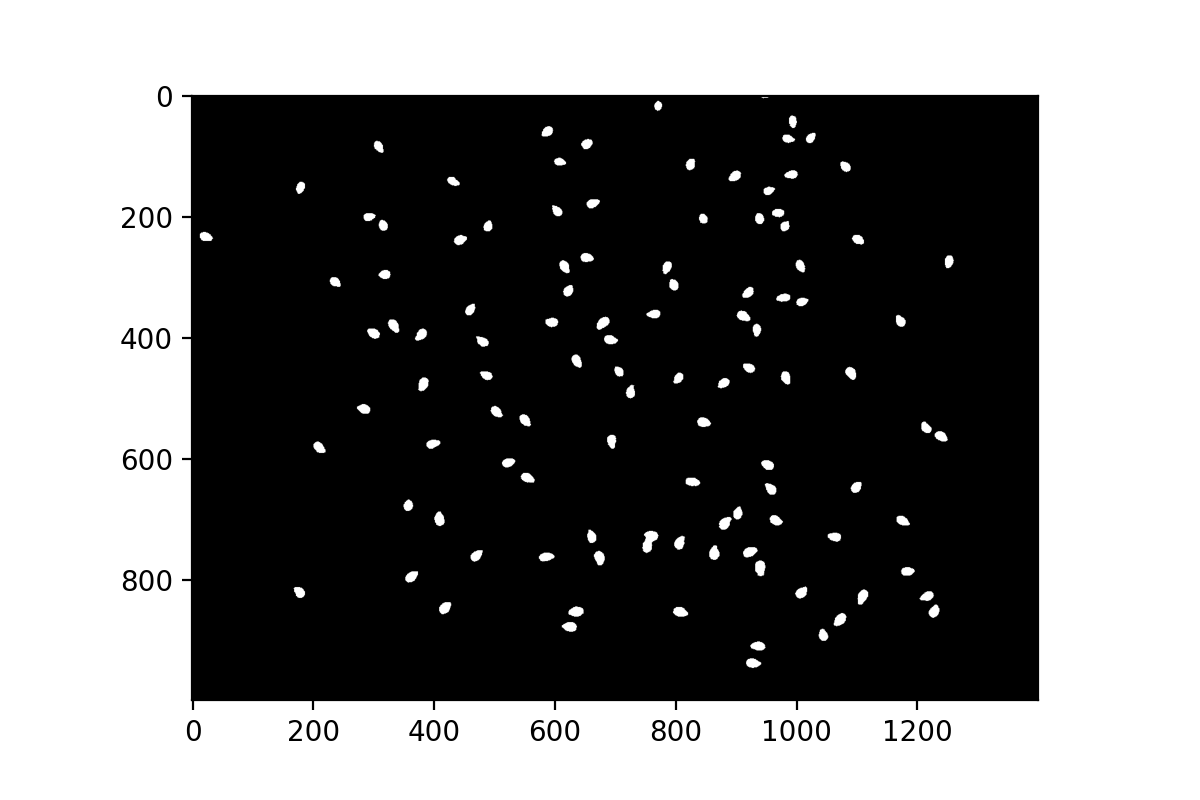

In [14]:
# Inputs:
#   bin_img - binary mask image
#   size - maximum size for objects that should be filled in as background (non-plant) pixels
b_fill = pcv.fill(bin_img=b_thresh, size=20)
#                                         ^
#                                         |
#                                 change this value


## Sección 3. Conteo y análisis de semillas

Para esto se necesita una máscara binaria completa


### Identificación simple de objetos

La máscara binaria se usa para encontrar objetos o contornos de cada una de las semillas. A diferencia de la función find_objects, esta aplicación usa la función findContours del programa OpenCV con la entrada cv2.RETR_EXTERNAL que ignora contornos en capas. La salida de este paso se puede usar para contar semillas, pero no se puede usar como entrada para análisis de color o forma.

In [15]:
# Inputs:
#   mask = binary mask with extra noise filled in
objects = cv2.findContours(b_fill, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

### Conteo de semillas

Cuenta el número de semillas (objetos simples) mediante el acceso al número de valores almacenados en el segundo item de la lista de objetos.

In [17]:
# Find number of seeds

# Inputs:
#    contours = list of contours
number_seeds = len(objects[1])
print(len(objects[1]))

108


In [29]:
#Se convierte los datos de la imagen en boolean (blanco =True, negro = False)

arraybool=np.array(b_fill, dtype=bool)


#El número de Euler (número entero) calcula el número de objetos menos el número de
#agujeros en los objetos.
#Se usa la función euler de la librería mahotas

#parámetros:
    #-imagen binaria de dos dimensiones
    #- Entero, conectividad. Opciones: 4 u 8. Default: 8
    #-mode: {‘reflect’, ‘nearest’, ‘wrap’, ‘mirror’, ‘constant’ [default]}
    
nsemillas=mahotas.euler(arraybool,8)
print('Número de semillas:', nsemillas)


# Create a new measurement
#pcv.outputs.add_observation(sample='default', variable='nsemillas', 
#                            trait='Number of seeds',
#                            method='cuenta de semillas', scale='number', datatype=int,
#                            value=nsemillas, label='number_of_seeds')


pcv.outputs.add_observation('nsemillas', 
                            'Number of seeds',
                            'cuenta de semillas', 'number', int,
                            nsemillas, 'number_of_seeds')

Número de semillas: 108.0


### Identificación de semillas para el análisis de forma y color

Para el análisis de color y forma, se requiere usar la función find_objects del programa PlantCV para obtener los objectos y la jerarquía de los objetos que necesitamos como entradas en los siguientes análisis.

Las funciones findContours de OpenCV y find_objects de PlantCV no se comportan de la misma manera ni tampoco proveen el mismo tipo de salidas, y por eso se deben identificar los objetos dos veces en este programa.

<IPython.core.display.Javascript object>


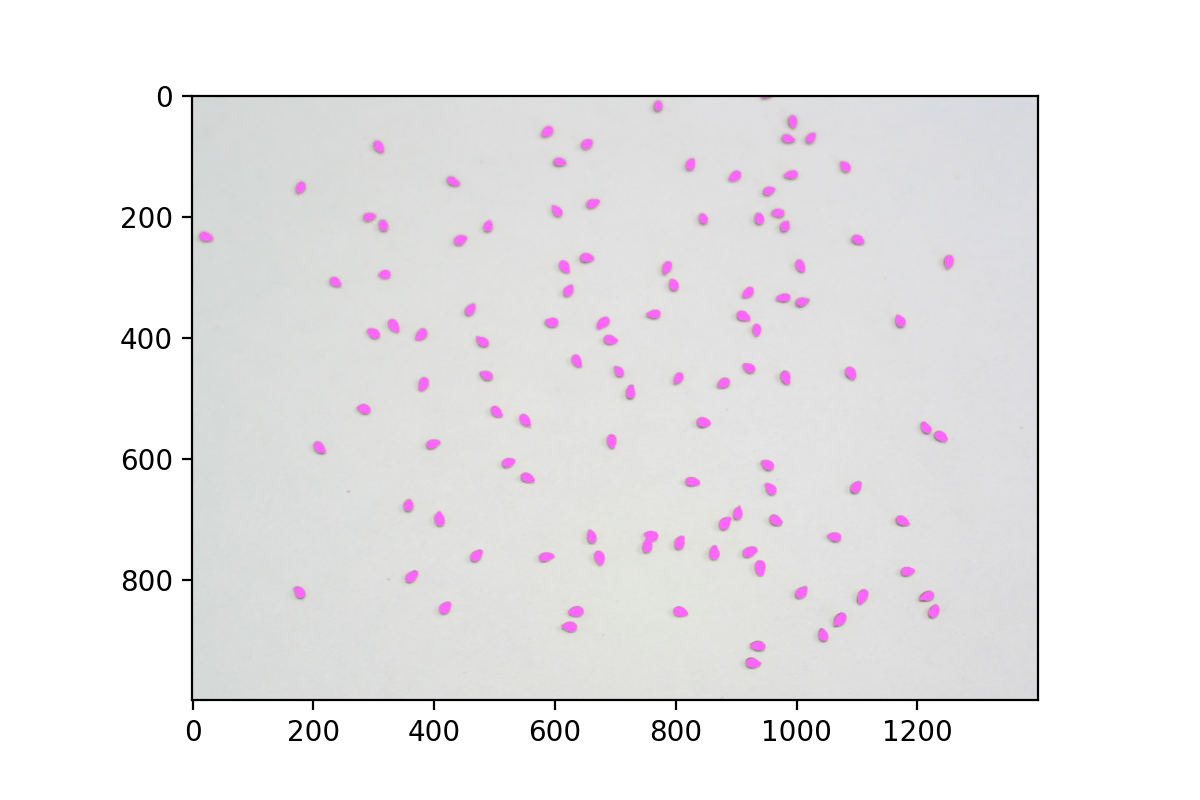

In [30]:
# Inputs:
#   img  = rgb image
#   mask = binary mask
objects2, obj_hierarchy = pcv.find_objects(img=img, mask=b_fill)

### Mediciones en cada semilla

Para hacer mediciones en cada semilla, se tienen que hacer iteraciones en cada objeto (lo cual sucede cuando obj_hierarchy[0][i][3] == -1. Para cada objeto, se siguen los siguientes pasos:
1. Se consolidan los contornos, de tal forma que todos los contornos que corresponden a una semilla se compilan en un objeto simple y con una máscara.
2. Se analiza la forma de la semilla.
3. Se analiza el color de la semilla


In [34]:
# Se crea una copia de la imagen RGB para el análisis de forma
# Entradas:
#   img = image
shape_img = np.copy(img)

# Se elimina la opción de presentar gráficas o imágenes
pcv.params.debug = None

# Hace iteraciones sobre todos los objetos en objects2 y se hace el análisis de forma y color
# for i in range(0, len(objects2)): 
# El bucle anterior consume demasiada memoria, pero idealmente se hace el bucle por cada semilla


# Con un propósito demostrativo, se hace el bucle solo con los primeros 15 objetos
for i in range(0, 15):
    # Se verifica si el objeto tiene una rama en la jerarquía
    if obj_hierarchy[0][i][3] == -1:
        # Crea un objeto y una máscara para un objeto (semilla)
        #
        # Entradas:
        #   img - rgb image
        #   contours - list entry i in objects2
        #   hierarchy - np.array of obj_hierarchy[0][1]
        seed, seed_mask = pcv.object_composition(img=img, contours=[objects2[i]], hierarchy=np.array([[obj_hierarchy[0][i]]]))
        
        # Analiza la forma de cada semilla
        #
        # Entradas:
        #   img - rgb image
        #   obj - seed
        #   mask - mask created of single seed
        #   label - label for each seed in image
        shape_img = pcv.analyze_object(img=shape_img, obj=seed, mask=seed_mask) # f"seed{i}")
        
        # Analiza el color de cada semilla
        #
        # Entradas:
        #   img - rgb image
        #   obj - seed
        #   hist_plot_type - 'all', or None for no histogram plot
        #   label - 'default'      
        color_img = pcv.analyze_color(rgb_img=img, mask=b_fill, hist_plot_type=None)
  

### Visualización del análisis de forma de las semillas

Durante la secuencia del bucle anterior se desactivó la opción de gráficado y de impresión de imágenes para evitar la reducción significativa de la velocidad de proceso. Ahora, se pueden presentar  las imágenes de los análisis de forma y color para asegurarnos que los resultados están bien.


<IPython.core.display.Javascript object>


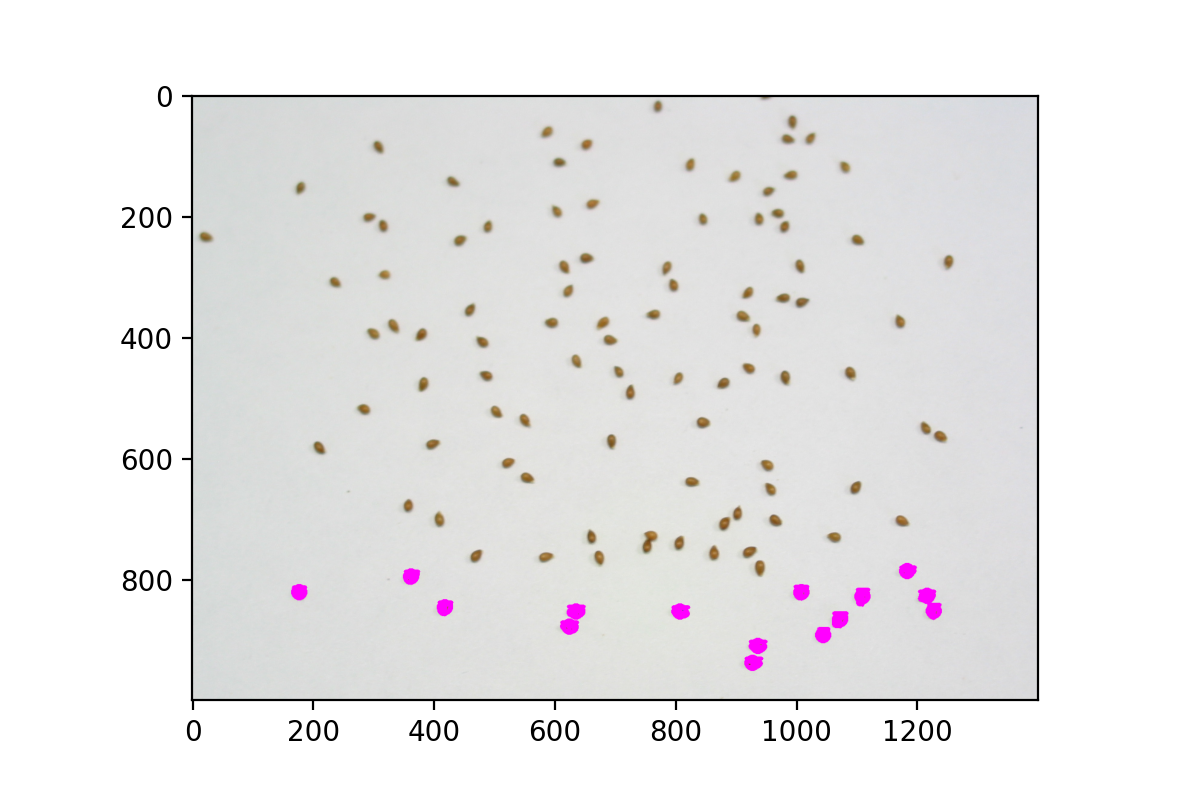

In [35]:
# Entradas:
#   img = image for shape analysis
forma= pcv.plot_image(img=shape_img)

In [36]:
# Entradas:
#   img = image for color analysis
color= pcv.plot_image(img=color_img)

### Enviar los resultados a un archivo

Los resultados se almacenan en una memoria provisional. Para almacenarlos en un archivo se usa la función  save_outputs. Las variables obtenidas con la función analyze_object son: área del objeto, superficie de la envolvente convexa, 'solidity', perímetro, ancho, alto, 'longest path', centro de masa, 'convex_hull_vertices', 'object_in_frame, 'ellipse_center, 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', y 'ellipse_eccentricity. Las variables obntenidas con la función analyze_color son las frecuencias de las variables de color. En este ejemplo, los resultados se guardan en un archivo CSV. Sin embargo, cuando el programa se ejecuta en paralelo, es decir cuando se procesan varias imágenes a la vez, entonces los resultados solo se pueden almacenar en el formato json.

In [39]:
# Entradas:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format or "csv" tabular format

pcv.print_results(filename=args.result)